In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.25)
plt.rcParams["figure.figsize"] = [8, 6]

In [14]:
data = pd.read_csv('timings_agg_revision.csv')
categories = pd.read_csv("../../2phase_nsa/categories/ce_categories.csv")[["query","well_behaved"]].set_index("query")
data = pd.merge(data, categories, left_on="query", right_index=True)
data

,query,method,total_time,execution_time,hashjoin_time,well_behaved
0,dblp_acyclic_201_00,DF-Bin,NaN,1.395854,1.277622,True
1594,dblp_acyclic_201_00,SYA,NaN,0.783645,0.666536,True
3188,dblp_acyclic_201_00,DuckDB-Bin,1.118311,0.859715,0.824105,True
5226,dblp_acyclic_201_00,Umbra-Default,0.775510,0.746485,NaN,True
6833,dblp_acyclic_201_00,Umbra-L&E,0.757904,0.707665,NaN,True
...,...,...,...,...,...,...
5618,yago_acyclic_tree_6_79,Umbra-Default,0.030941,0.002179,NaN,True
7225,yago_acyclic_tree_6_79,Umbra-L&E,0.048084,0.001528,NaN,True
4452,yago_acyclic_chain_12_36,DuckDB-Bin,9.130138,6.082311,5.548175,False
5303,yago_acyclic_chain_12_36,Umbra-Default,0.063986,0.007509,NaN,False


In [15]:
# Create one table for each method
df_bin = data[data["method"] == "DF-Bin"].drop(columns=["method"]).set_index("query")
sya = data[data["method"] == "SYA"].drop(columns=["method"]).set_index("query") 
duckdb_bin = data[data["method"] == "DuckDB-Bin"].drop(columns=["method"]).set_index("query") 
umbra_default = data[data["method"] == "Umbra-Default"].drop(columns=["method"]).set_index("query")
umbra_le = data[data["method"] == "Umbra-L&E"].drop(columns=["method"]).set_index("query")

In [16]:
joinmethod = "inner"
merged =  pd.merge(
                pd.merge(
                    pd.merge(
                        pd.merge(duckdb_bin,df_bin, on="query", suffixes=("_duckdbbin", "_dfbin"), how=joinmethod),
                        sya.add_suffix("_sya"), on="query", how=joinmethod
                    ),
                    umbra_default.add_suffix("_umbra_default"), on="query", how=joinmethod
                ), 
                umbra_le.add_suffix("_umbra_le"), on="query", how=joinmethod
            ).drop(columns=["well_behaved_duckdbbin", "well_behaved_dfbin","well_behaved_umbra_default","well_behaved_umbra_le"]).rename(columns={"well_behaved_sya": "well_behaved"})
merged

,total_time_duckdbbin,execution_time_duckdbbin,hashjoin_time_duckdbbin,total_time_dfbin,execution_time_dfbin,hashjoin_time_dfbin,total_time_sya,execution_time_sya,hashjoin_time_sya,well_behaved,total_time_umbra_default,execution_time_umbra_default,hashjoin_time_umbra_default,total_time_umbra_le,execution_time_umbra_le,hashjoin_time_umbra_le
query,,,,,,,,,,,,,,,,
dblp_acyclic_201_00,1.118311,0.859715,0.824105,NaN,1.395854,1.277622,NaN,0.783645,0.666536,True,0.775510,0.746485,NaN,0.757904,0.707665,NaN
dblp_acyclic_201_01,0.166843,0.147681,0.125715,NaN,0.236780,0.131036,NaN,0.191551,0.086848,True,0.146805,0.118030,NaN,0.134325,0.083367,NaN
dblp_acyclic_201_02,0.234484,0.205610,0.179452,NaN,0.276294,0.186719,NaN,0.238054,0.148587,True,0.172646,0.143307,NaN,0.115497,0.064702,NaN
dblp_acyclic_201_03,0.826783,0.590417,0.561459,NaN,0.927781,0.824711,NaN,0.561408,0.459905,True,0.641862,0.612527,NaN,0.483446,0.434311,NaN
dblp_acyclic_201_04,0.420088,0.350535,0.313139,NaN,0.458164,0.330471,NaN,0.305297,0.179379,True,0.163035,0.134151,NaN,0.140407,0.090190,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yago_acyclic_tree_6_75,0.258555,0.248308,0.204962,NaN,0.265963,0.130620,NaN,0.297645,0.159561,True,0.062219,0.032793,NaN,0.073513,0.027083,NaN
yago_acyclic_tree_6_76,0.055133,0.052372,0.043944,NaN,0.056429,0.032254,NaN,0.052425,0.028067,False,0.038912,0.009145,NaN,0.052594,0.006905,NaN
yago_acyclic_tree_6_77,0.039601,0.027772,0.025055,NaN,0.026384,0.024009,NaN,0.007968,0.005543,False,0.032371,0.002753,NaN,0.051184,0.001907,NaN


In [17]:
def scatterplot(data, x, y, label_col: str|None = None, min=1e-4, max=1e2):
    if label_col is not None:
        ax = sns.scatterplot(data, x=x, y=y, hue=data[label_col],palette={False:"tab:orange", True:"tab:blue"})
    else:
        ax = sns.scatterplot(data, x=x, y=y, color="b")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot([min, max], [min, max], color='grey', linestyle='-', alpha=0.5)
    return ax

def print_speedups(data: pd.DataFrame, x: str, y: str):
    speedups = data[x] / data[y]
    print("Avg. speedup:       {:.3f}x".format(speedups.mean()))
    print("Median speedup:     {:.3f}x".format(speedups.median()))
    abs_speedups = data[x] - data[y]
    print("Avg. abs. speedup:       {:.3f}s".format(abs_speedups.mean()))
    print("Median abs. speedup:     {:.3f}s".format(abs_speedups.median()))
    max_slowdown = (data[y] / data[x]).max()
    max_slowdown_query = data[data[y] / data[x] == max_slowdown].index[0]
    x_time = data.loc[max_slowdown_query, x]
    y_time = data.loc[max_slowdown_query, y]
    print("Max. slowdown:      {:.3f}x \t(query {:s}, x={:.3f}s, y={:.3f}s)".format(max_slowdown, max_slowdown_query, x_time, y_time))

    max_abs_slowdown = (data[y] - data[x]).max()
    max_abs_slowdown_query = data[(data[y] - data[x]) == max_abs_slowdown].index[0]
    x_time = data.loc[max_abs_slowdown_query, x]
    y_time = data.loc[max_abs_slowdown_query, y]
    print("Max. abs. slowdown: {:.3f}s \t(query {:s}, x={:.3f}s, y={:.3f}s)".format(max_abs_slowdown, max_abs_slowdown_query, x_time, y_time))

    max_speedup = (data[x] / data[y]).max()
    max_speedup_query = data[data[x] / data[y] == max_speedup].index[0]
    x_time = data.loc[max_speedup_query, x]
    y_time = data.loc[max_speedup_query, y]
    print("Max. speedup:       {:.3f}x \t(query {:s}, x={:.3f}s, y={:.3f}s)".format(max_speedup, max_speedup_query, x_time, y_time))

    max_abs_speedup = (data[x] - data[y]).max()
    max_abs_speedup_query = data[(data[x] - data[y]) == max_abs_speedup].index[0]
    x_time = data.loc[max_abs_speedup_query, x]
    y_time = data.loc[max_abs_speedup_query, y]
    print("Max. abs. speedup:  {:.3f}s \t(query {:s}, x={:.3f}s, y={:.3f}s)".format(max_abs_speedup, max_abs_speedup_query, x_time, y_time))
    print("-----------------------------------------------")

def print_stats(ratio_col: pd.Series, epsilon: float = 0.01):
    n_rows = len(ratio_col.dropna())
    n_above = ratio_col[ratio_col > 1+epsilon].shape[0]
    n_below = ratio_col[ratio_col < 1-epsilon].shape[0]
    n_equal = ratio_col[(ratio_col >= 1-epsilon) & (ratio_col <= 1+epsilon)].shape[0]

    print(f"Total: {n_rows}, epsilon: {epsilon}")
    print("Number of dots above the line:", n_above, f"({n_above/n_rows*100:.2f}%)")
    print("Number of dots below the line:", n_below , f"({n_below/n_rows*100:.2f}%)")
    print("Number of dots on the line", n_equal, f"({n_equal/n_rows*100:.2f}%)")

## DuckDB vs DataFusion

In [18]:
x = "hashjoin_time_duckdbbin"
y = "hashjoin_time_dfbin"

print_speedups(merged, x, y)
print_stats(ratio_col = merged[y] / merged[x])
# scatterplot(merged, x, y, "well_behaved")
merged[[x,y]].dropna().to_csv("ce_jointime_duckdbbin_vs_dfbin.dat", sep=" ", header=True, index=True)

Avg. speedup:       1.749x
Median speedup:     1.137x
Avg. abs. speedup:       0.166s
Median abs. speedup:     0.004s
Max. slowdown:      5.580x 	(query yago_acyclic_tree_6_38, x=2.189s, y=12.214s)
Max. abs. slowdown: 12.096s 	(query watdiv_acyclic_210_07, x=3.202s, y=15.298s)
Max. speedup:       18.458x 	(query yago_acyclic_star_6_34, x=0.245s, y=0.013s)
Max. abs. speedup:  72.621s 	(query dblp_acyclic_212_16, x=77.537s, y=4.916s)
-----------------------------------------------
Total: 1594, epsilon: 0.01
Number of dots above the line: 623 (39.08%)
Number of dots below the line: 945 (59.28%)
Number of dots on the line 26 (1.63%)


In [19]:
x = "execution_time_duckdbbin"
y = "execution_time_dfbin"

print_speedups(merged, x, y)
print_stats(ratio_col = merged[y] / merged[x], epsilon=0.001)
# scatterplot(merged, x, y, "well_behaved")
merged[[x,y]].dropna().to_csv("ce_executiontime_duckdbbin_vs_dfbin.dat", sep=" ", header=True, index=True)

Avg. speedup:       1.391x
Median speedup:     0.901x
Avg. abs. speedup:       0.138s
Median abs. speedup:     -0.002s
Max. slowdown:      5.511x 	(query yago_acyclic_tree_6_38, x=2.238s, y=12.334s)
Max. abs. slowdown: 11.698s 	(query watdiv_acyclic_210_07, x=3.670s, y=15.368s)
Max. speedup:       16.159x 	(query watdiv_acyclic_218_06, x=6.380s, y=0.395s)
Max. abs. speedup:  72.581s 	(query dblp_acyclic_212_16, x=77.555s, y=4.974s)
-----------------------------------------------
Total: 1594, epsilon: 0.001
Number of dots above the line: 905 (56.78%)
Number of dots below the line: 688 (43.16%)
Number of dots on the line 1 (0.06%)


## DF-Bin v.s. SYA

Avg. speedup:       2.101x
Median speedup:     1.325x
Avg. abs. speedup:       0.198s
Median abs. speedup:     0.013s
Max. slowdown:      4.410x 	(query yago_acyclic_chain_12_73, x=0.201s, y=0.886s)
Max. abs. slowdown: 0.685s 	(query yago_acyclic_chain_12_73, x=0.201s, y=0.886s)
Max. speedup:       90.419x 	(query yago_acyclic_star_6_39, x=0.342s, y=0.004s)
Max. abs. speedup:  14.942s 	(query watdiv_acyclic_210_07, x=15.298s, y=0.356s)
-----------------------------------------------
Total: 1594, epsilon: 0.01
Number of dots above the line: 265 (16.62%)
Number of dots below the line: 1284 (80.55%)
Number of dots on the line 45 (2.82%)


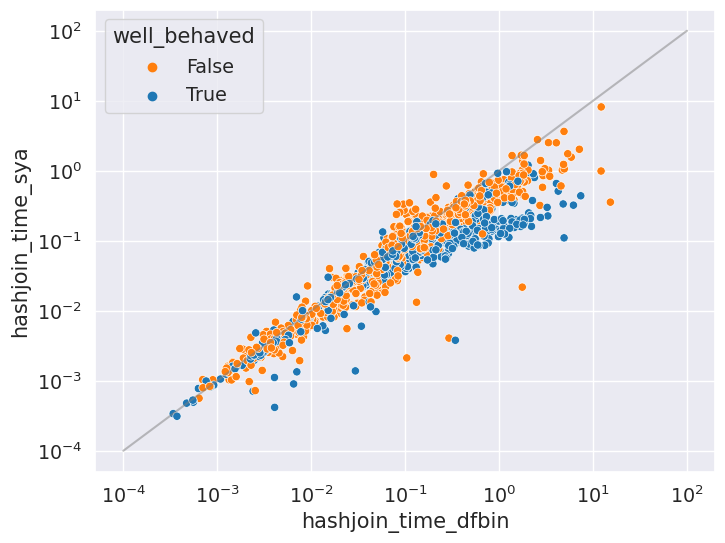

In [20]:
x = "hashjoin_time_dfbin"
y = "hashjoin_time_sya"

print_speedups(merged, x, y)
print_stats(ratio_col = merged[y] / merged[x])
scatterplot(merged, x, y, "well_behaved")
merged[[x,y,"well_behaved"]].dropna().to_csv("ce_jointime_dfbin_vs_sya.dat", sep=" ", header=True, index=True)

Avg. speedup:       1.806x
Median speedup:     1.205x
Avg. abs. speedup:       0.199s
Median abs. speedup:     0.014s
Max. slowdown:      2.515x 	(query yago_acyclic_chain_12_39, x=0.171s, y=0.430s)
Max. abs. slowdown: 0.701s 	(query yago_acyclic_chain_12_73, x=0.464s, y=1.164s)
Max. speedup:       62.539x 	(query yago_acyclic_star_6_39, x=0.345s, y=0.006s)
Max. abs. speedup:  14.958s 	(query watdiv_acyclic_210_07, x=15.368s, y=0.410s)
-----------------------------------------------
Total: 1594, epsilon: 0.01
Number of dots above the line: 258 (16.19%)
Number of dots below the line: 1260 (79.05%)
Number of dots on the line 76 (4.77%)


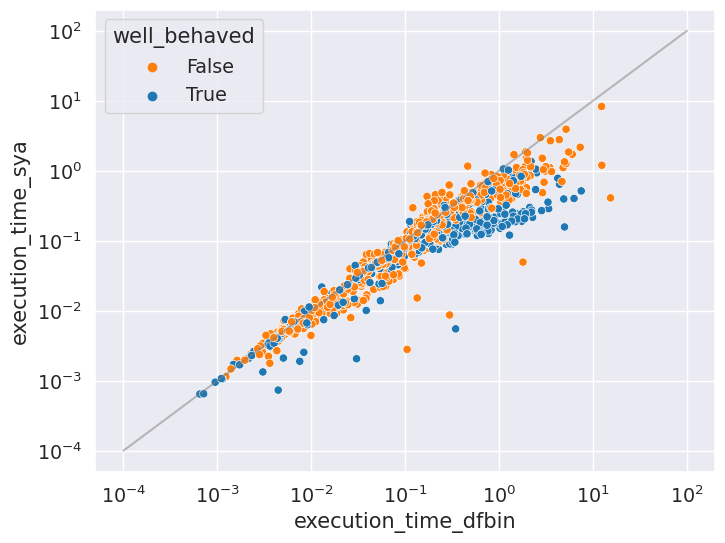

In [21]:
x = "execution_time_dfbin"
y = "execution_time_sya"

print_speedups(merged, x, y)
print_stats(ratio_col = merged[y] / merged[x])
scatterplot(merged, x, y, "well_behaved")
merged[[x,y,"well_behaved"]].dropna().to_csv("ce_executiontime_dfbin_vs_sya.dat", sep=" ", header=True, index=True)

In [22]:
x = "execution_time_dfbin"
y = "execution_time_sya"

tmp = merged[merged["well_behaved"] ==  True]
print_speedups(tmp, x, y)
print_stats(ratio_col = tmp[y] / tmp[x])
# scatterplot(tmp, x, y, "well_behaved")

Avg. speedup:       2.077x
Median speedup:     1.195x
Avg. abs. speedup:       0.213s
Median abs. speedup:     0.014s
Max. slowdown:      1.688x 	(query job_acyclic_103_64, x=0.112s, y=0.188s)
Max. abs. slowdown: 0.077s 	(query job_acyclic_103_64, x=0.112s, y=0.188s)
Max. speedup:       62.539x 	(query yago_acyclic_star_6_39, x=0.345s, y=0.006s)
Max. abs. speedup:  6.973s 	(query job_acyclic_102_75, x=7.488s, y=0.515s)
-----------------------------------------------
Total: 710, epsilon: 0.01
Number of dots above the line: 69 (9.72%)
Number of dots below the line: 604 (85.07%)
Number of dots on the line 37 (5.21%)


In [23]:
x = "execution_time_dfbin"
y = "execution_time_sya"

tmp = merged[merged["well_behaved"] ==  False]
print_speedups(tmp, x, y)
print_stats(ratio_col = tmp[y] / tmp[x])
# scatterplot(tmp, x, y, "well_behaved")

Avg. speedup:       1.587x
Median speedup:     1.210x
Avg. abs. speedup:       0.189s
Median abs. speedup:     0.013s
Max. slowdown:      2.515x 	(query yago_acyclic_chain_12_39, x=0.171s, y=0.430s)
Max. abs. slowdown: 0.701s 	(query yago_acyclic_chain_12_73, x=0.464s, y=1.164s)
Max. speedup:       37.517x 	(query watdiv_acyclic_210_07, x=15.368s, y=0.410s)
Max. abs. speedup:  14.958s 	(query watdiv_acyclic_210_07, x=15.368s, y=0.410s)
-----------------------------------------------
Total: 884, epsilon: 0.01
Number of dots above the line: 189 (21.38%)
Number of dots below the line: 656 (74.21%)
Number of dots on the line 39 (4.41%)


# Umbra-L&E speedup

In [24]:
x = "execution_time_umbra_default"
y = "execution_time_umbra_le"

print_speedups(merged, x, y)

Avg. speedup:       1.648x
Median speedup:     1.439x
Avg. abs. speedup:       0.063s
Median abs. speedup:     0.005s
Max. slowdown:      3.050x 	(query yago_acyclic_chain_9_62, x=0.102s, y=0.311s)
Max. abs. slowdown: 0.209s 	(query yago_acyclic_chain_9_62, x=0.102s, y=0.311s)
Max. speedup:       16.824x 	(query job_acyclic_102_79, x=4.111s, y=0.244s)
Max. abs. speedup:  5.117s 	(query yago_acyclic_tree_6_38, x=6.246s, y=1.129s)
-----------------------------------------------
